In [1]:
%matplotlib inline


# Logistic function

Shown in the plot is how the logistic regression would, in this
synthetic dataset, classify values as either 0 or 1,
i.e. class one or two, using the logistic curve.


Automatically created module for IPython interactive environment
[[   0   21 2017    0    0    4    0    1    0    0    0]
 [   0   18 2011    0    0    0    0    1    0    0    2]
 [   0   19 2013    0    0    5    0    0    0    0    0]
 [   0   26 2013    1    1    5    0    0    0    0    0]
 [   0   21 2010    0    0    4    1    0    1    1    0]
 [   0   33 2011    1    0    5    0    0    0    0    0]
 [   0   24 2015    0    0    5    0    0    0    0    0]
 [   0   20 2014    1    0    5    0    0    0    0    0]
 [   0   21 2015    1    0    5    0    0    0    0    0]
 [   0   19 2014    1    1    1    3    1    5    0    0]]
[[   0   34 2014    1    1    5    0    0    0    0    0]
 [   0   19 2013    1    0    5    0    0    0    0    0]
 [   0   21 2016    0    0    5    0    0    0    0    0]
 [   0   22 2016    0    0    4    0    1    1    0    1]
 [   0   28 2014    1    1    0    0    5    0    2    4]
 [   0   31 2011    1    0    4    1    0    0    1    1]
 [   0

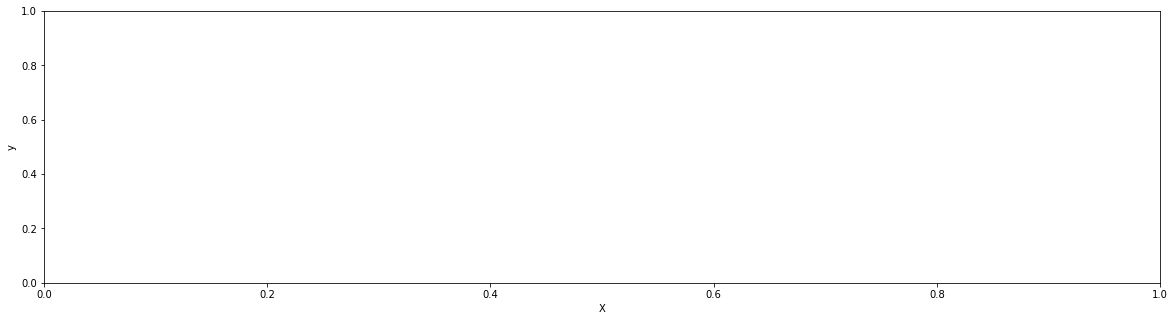

In [45]:
print(__doc__)


# Code source: Gael Varoquaux
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from numpy import genfromtxt
from sklearn import linear_model
from scipy.special import expit
from sklearn.model_selection import train_test_split


# np.savetxt('myfile.csv', X, delimiter=',')
my_data = genfromtxt('dataset - sinnulos - simple.csv', dtype=int, delimiter=';')

X = my_data[:,:11] #no toma el 11
y = my_data[:,11]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(X_train[0:10,:])
print(X_test[0:10,:])


# Fit the classifier
clf = linear_model.LogisticRegression(max_iter=300)
clf.fit(X, y)
print(clf.n_iter_)


# and plot the result
plt.figure(1, figsize=(20, 5))
plt.clf()
#plt.scatter(X[:,1].ravel(), y, color='black', zorder=20)

#plt.hist(X[:,1].ravel(), bins='auto')



X_test = np.linspace(-5, 10, 300)

print(clf.coef_)
print(clf.intercept_)


#loss = expit(X_test * clf.coef_ + clf.intercept_).ravel()
#plt.plot(X_test, loss, color='red', linewidth=3)

#ols = linear_model.LinearRegression()
#ols.fit(X, y)
#plt.plot(X_test, ols.coef_ * X_test + ols.intercept_, linewidth=1)
#plt.axhline(.5, color='.5')

plt.ylabel('y')
plt.xlabel('X')
#plt.xticks(range(10, 70,2))
#plt.yticks([0, 0.5, 1])
#plt.ylim(-.25, 1.25)
#plt.xlim(10, 70)
#plt.legend(('Logistic Regression Model', 'Linear Regression Model'), loc="lower right", fontsize='small')
#plt.tight_layout()
plt.show()